In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import options, index and rates data

In [200]:
# import options data
data = pd.read_csv("NDXP.csv").sort_values(by=['quote_date', 'strike']).reset_index(drop = True)
data['quote_date'] = pd.to_datetime(data['quote_date'])
data['expiration'] = pd.to_datetime(data['expiration'])
data

,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-04,2018-02-02,6200.0,C,401.9,423.0
1,2018-01-04,2018-02-02,6200.0,P,11.8,16.0
2,2018-01-04,2018-02-09,6200.0,C,406.2,427.0
3,2018-01-04,2018-02-09,6200.0,P,18.7,23.0
4,2018-01-04,2018-02-23,6200.0,C,417.5,439.0
...,...,...,...,...,...,...
7226456,2022-12-30,2023-01-06,16000.0,P,5106.0,5122.1
7226457,2022-12-30,2023-01-13,16000.0,C,0.0,0.9
7226458,2022-12-30,2023-01-13,16000.0,P,5089.8,5106.2
7226459,2022-12-30,2023-01-27,16000.0,C,0.0,1.2


In [201]:
NDX_100 = pd.read_csv('NDX100_Data.csv')
NDX_100.rename(columns = {'Close/Last':'NDX_Exp'}, inplace = True)
NDX_100['Date'] = pd.to_datetime(NDX_100['Date'])
NDX_100

,Date,NDX_Exp
0,2024-01-05,16305.98
1,2024-01-04,16282.01
2,2024-01-03,16368.49
3,2024-01-02,16543.94
4,2023-12-29,16825.93
...,...,...
2530,2014-01-10,3565.08
2531,2014-01-09,3552.58
2532,2014-01-08,3567.54
2533,2014-01-07,3557.85


In [202]:
# import interest rate data
rates = pd.read_csv("DGS1MO.csv").ffill()
rates.replace('.', pd.NA, inplace=True)
rates.columns = ['date','rate']
rates['date'] = pd.to_datetime(rates['date'])
rates['rate'] = (pd.to_numeric(rates['rate'])/100).fillna(method='ffill')
rates

,date,rate
0,2018-01-02,0.0129
1,2018-01-03,0.0129
2,2018-01-04,0.0128
3,2018-01-05,0.0127
4,2018-01-08,0.0130
...,...,...
1299,2022-12-26,0.0380
1300,2022-12-27,0.0387
1301,2022-12-28,0.0386
1302,2022-12-29,0.0404


## Filter second fridays, (and thursdays if fridays don't exist)

In [203]:
# second fridays between 2018 and 2022

all_fridays = pd.date_range(start="2018-01-01", end="2022-12-31", freq='W-FRI') ## all fridays in the period

second_fridays = [] # initialize second fridays list

for friday in all_fridays: # loop through every friday and determine if it is second friday
    month_start = pd.offsets.MonthBegin(1) # create a date offset to move friday to start of the month
    if len(pd.date_range(start = friday - month_start, end = friday, freq='W-FRI')) == 2: # if number of fridays since start of month is 2:
        second_fridays.append(friday)

second_fridays = pd.Series(second_fridays)
old_date = pd.to_datetime('2020-04-10')
new_date = pd.to_datetime('2020-04-09')
index = second_fridays[second_fridays == old_date].index
second_fridays.at[index[0]] = new_date
second_fridays

0    2018-01-12
1    2018-02-09
2    2018-03-09
3    2018-04-13
4    2018-05-11
5    2018-06-08
6    2018-07-13
7    2018-08-10
8    2018-09-14
9    2018-10-12
10   2018-11-09
11   2018-12-14
12   2019-01-11
13   2019-02-08
14   2019-03-08
15   2019-04-12
16   2019-05-10
17   2019-06-14
18   2019-07-12
19   2019-08-09
20   2019-09-13
21   2019-10-11
22   2019-11-08
23   2019-12-13
24   2020-01-10
25   2020-02-14
26   2020-03-13
27   2020-04-09
28   2020-05-08
29   2020-06-12
30   2020-07-10
31   2020-08-14
32   2020-09-11
33   2020-10-09
34   2020-11-13
35   2020-12-11
36   2021-01-08
37   2021-02-12
38   2021-03-12
39   2021-04-09
40   2021-05-14
41   2021-06-11
42   2021-07-09
43   2021-08-13
44   2021-09-10
45   2021-10-08
46   2021-11-12
47   2021-12-10
48   2022-01-14
49   2022-02-11
50   2022-03-11
51   2022-04-08
52   2022-05-13
53   2022-06-10
54   2022-07-08
55   2022-08-12
56   2022-09-09
57   2022-10-14
58   2022-11-11
59   2022-12-09
dtype: datetime64[ns]

In [204]:
# get second-friday expirations
second_friday_exp = data[data['expiration'].isin(second_fridays)]
day_difference = (second_friday_exp['expiration'] - second_friday_exp['quote_date']).dt.days
data_28_days = second_friday_exp[day_difference == 28]
unmatched_expiration_dates = second_friday_exp.loc[~second_friday_exp['expiration'].isin(data_28_days['expiration']), 'expiration']
data_29_days = second_friday_exp[(day_difference == 29) & second_friday_exp['expiration'].isin(unmatched_expiration_dates)]
second_friday_data = pd.concat([data_28_days, data_29_days]).reset_index(drop=True)
second_friday_data


,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-12,2018-02-09,5400.0,C,1347.00,1368.30
1,2018-01-12,2018-02-09,5400.0,P,0.05,3.10
2,2018-01-12,2018-02-09,5500.0,C,1248.00,1269.00
3,2018-01-12,2018-02-09,5500.0,P,0.25,3.70
4,2018-01-12,2018-02-09,5600.0,C,1151.60,1165.90
...,...,...,...,...,...,...
22875,2022-04-14,2022-05-13,19500.0,P,5555.10,5580.00
22876,2022-04-14,2022-05-13,19600.0,C,0.00,0.75
22877,2022-04-14,2022-05-13,19600.0,P,5655.00,5679.90
22878,2022-04-14,2022-05-13,19700.0,C,0.00,0.75


## Check for bogus price data (bid > ask)

In [205]:
# Make sure bid < ask ( buy < sell)
second_friday_data = second_friday_data[second_friday_data['bid_1545'] < second_friday_data['ask_1545']]
second_friday_data

,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-12,2018-02-09,5400.0,C,1347.00,1368.30
1,2018-01-12,2018-02-09,5400.0,P,0.05,3.10
2,2018-01-12,2018-02-09,5500.0,C,1248.00,1269.00
3,2018-01-12,2018-02-09,5500.0,P,0.25,3.70
4,2018-01-12,2018-02-09,5600.0,C,1151.60,1165.90
...,...,...,...,...,...,...
22875,2022-04-14,2022-05-13,19500.0,P,5555.10,5580.00
22876,2022-04-14,2022-05-13,19600.0,C,0.00,0.75
22877,2022-04-14,2022-05-13,19600.0,P,5655.00,5679.90
22878,2022-04-14,2022-05-13,19700.0,C,0.00,0.75


## Use Put-Call Parity to find NDX values on quote date 15:45

In [206]:
# organise puts and calls for each strike and date
calls = second_friday_data[second_friday_data['option_type'] == "C"]
puts = second_friday_data[second_friday_data['option_type'] == "P"]
merged_options = pd.merge(calls, puts, on=['quote_date', 'strike'], suffixes=('_C','_P'), how='inner')[['quote_date',
                                                                                                     'expiration_C',
                                                                                                     'strike',
                                                                                                     'bid_1545_C',
                                                                                                     'ask_1545_C',
                                                                                                     'bid_1545_P',
                                                                                                     'ask_1545_P']]


# get 1 month rates on each date
merged_data = pd.merge(merged_options, rates, left_on='quote_date', right_on='date', how='left')

# use put call parity to get underlying price
merged_data['implied_S'] = (merged_data['bid_1545_C'] + merged_data['ask_1545_C'])/2 + merged_data['strike']/((1+merged_data['rate'])**(1/12)) - (merged_data['bid_1545_P'] + merged_data['ask_1545_P'])/2
merged_data['distance_to_strike'] = merged_data['implied_S'] - merged_data['strike']
merged_data

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S,distance_to_strike
0,2018-01-12,2018-02-09,5400.0,1347.0,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453
1,2018-01-12,2018-02-09,5500.0,1248.0,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054
2,2018-01-12,2018-02-09,5600.0,1151.6,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655
3,2018-01-12,2018-02-09,5700.0,1052.4,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256
4,2018-01-12,2018-02-09,5800.0,953.1,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857
...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-04-14,2022-05-13,19300.0,0.0,0.75,5355.20,5380.1,2022-04-14,0.0037,13926.786063,-5373.213937
11436,2022-04-14,2022-05-13,19400.0,0.0,0.75,5455.20,5480.0,2022-04-14,0.0037,13926.805291,-5473.194709
11437,2022-04-14,2022-05-13,19500.0,0.0,0.70,5555.10,5580.0,2022-04-14,0.0037,13926.799519,-5573.200481
11438,2022-04-14,2022-05-13,19600.0,0.0,0.75,5655.00,5679.9,2022-04-14,0.0037,13926.893747,-5673.106253


In [207]:
# might need to consider picking a single implied S (maybe one closest to at the money?)
def get_at_the_money(group): 
    return group.iloc[(group['distance_to_strike'].abs()).argmin()] # for each date, get most at the money strike
at_the_money_df = merged_data.groupby('quote_date').apply(get_at_the_money)[['quote_date', 'implied_S']] # pull out the calculated S for most at the money strike
at_the_money_df.reset_index(drop=True, inplace=True)
merged_data_new = pd.merge(merged_data, at_the_money_df, left_on='quote_date', right_on='quote_date', how='left')
merged_data_new

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y
0,2018-01-12,2018-02-09,5400.0,1347.0,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067
1,2018-01-12,2018-02-09,5500.0,1248.0,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067
2,2018-01-12,2018-02-09,5600.0,1151.6,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067
3,2018-01-12,2018-02-09,5700.0,1052.4,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067
4,2018-01-12,2018-02-09,5800.0,953.1,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067
...,...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-04-14,2022-05-13,19300.0,0.0,0.75,5355.20,5380.1,2022-04-14,0.0037,13926.786063,-5373.213937,13923.415041
11436,2022-04-14,2022-05-13,19400.0,0.0,0.75,5455.20,5480.0,2022-04-14,0.0037,13926.805291,-5473.194709,13923.415041
11437,2022-04-14,2022-05-13,19500.0,0.0,0.70,5555.10,5580.0,2022-04-14,0.0037,13926.799519,-5573.200481,13923.415041
11438,2022-04-14,2022-05-13,19600.0,0.0,0.75,5655.00,5679.9,2022-04-14,0.0037,13926.893747,-5673.106253,13923.415041


## Observe movements in Strikes and number of strikes available to trade every quote date

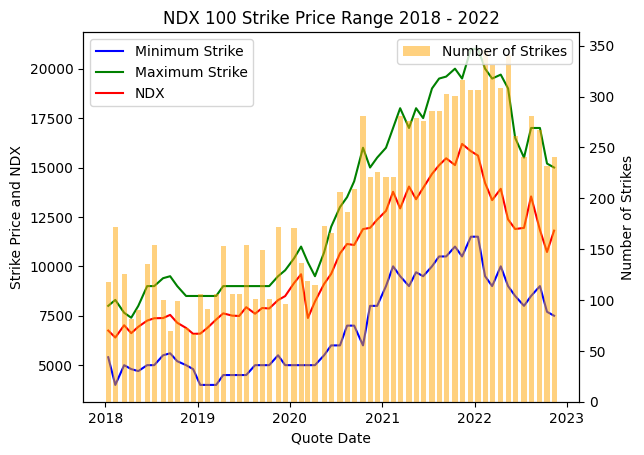

In [208]:
def strike_min(group):
    return group['strike'].min() # smallest strike on a given date

def strike_max(group):
    return group['strike'].max() # largest strike on a given date

def NDX(group):
    return group['implied_S_y'].max() # implied NDX on a given date

def group_length(group):
    return len(group)

fig, ax1 = plt.subplots()
ax1.plot(merged_data_new.groupby("quote_date").apply(strike_min), label="Minimum Strike", color='b')
ax1.plot(merged_data_new.groupby("quote_date").apply(strike_max), label="Maximum Strike", color='g')
ax1.plot(merged_data_new.groupby("quote_date").apply(NDX), label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')
# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(merged_data_new.groupby("quote_date").apply(lambda x: x.name), 
        merged_data_new.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("NDX 100 Strike Price Range 2018 - 2022")
plt.show()


## Strike Ratio Approach

In [209]:
merged_data_new["adjusted_strike"] = np.round(merged_data_new["strike"]/merged_data_new["implied_S_y"],3)
merged_data_new

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,adjusted_strike
0,2018-01-12,2018-02-09,5400.0,1347.0,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,0.800
1,2018-01-12,2018-02-09,5500.0,1248.0,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067,0.815
2,2018-01-12,2018-02-09,5600.0,1151.6,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067,0.829
3,2018-01-12,2018-02-09,5700.0,1052.4,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067,0.844
4,2018-01-12,2018-02-09,5800.0,953.1,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,0.859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-04-14,2022-05-13,19300.0,0.0,0.75,5355.20,5380.1,2022-04-14,0.0037,13926.786063,-5373.213937,13923.415041,1.386
11436,2022-04-14,2022-05-13,19400.0,0.0,0.75,5455.20,5480.0,2022-04-14,0.0037,13926.805291,-5473.194709,13923.415041,1.393
11437,2022-04-14,2022-05-13,19500.0,0.0,0.70,5555.10,5580.0,2022-04-14,0.0037,13926.799519,-5573.200481,13923.415041,1.401
11438,2022-04-14,2022-05-13,19600.0,0.0,0.75,5655.00,5679.9,2022-04-14,0.0037,13926.893747,-5673.106253,13923.415041,1.408


In [210]:
def adj_strike_min(group):
    return group['adjusted_strike'].min() # smallest adj strike on a given date

def adj_strike_max(group):
    return group['adjusted_strike'].max() # largest adj strike on a given date

subset_min = merged_data_new.groupby("quote_date").apply(adj_strike_min).max()
subset_max = merged_data_new.groupby("quote_date").apply(adj_strike_max).min()
print(subset_min, subset_max)

0.8 1.09


In [211]:
filtered_data = merged_data_new[(merged_data_new["adjusted_strike"] <= subset_max) & (merged_data_new["adjusted_strike"] >= subset_min)]
filtered_data

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,adjusted_strike
0,2018-01-12,2018-02-09,5400.0,1347.0,1368.3,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,0.800
1,2018-01-12,2018-02-09,5500.0,1248.0,1269.0,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067,0.815
2,2018-01-12,2018-02-09,5600.0,1151.6,1165.9,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067,0.829
3,2018-01-12,2018-02-09,5700.0,1052.4,1066.7,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067,0.844
4,2018-01-12,2018-02-09,5800.0,953.1,967.4,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,0.859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11290,2022-04-14,2022-05-13,15075.0,37.2,40.0,1172.20,1194.5,2022-04-14,0.0037,13925.611167,-1149.388833,13923.415041,1.083
11291,2022-04-14,2022-05-13,15100.0,34.5,37.6,1194.80,1217.2,2022-04-14,0.0037,13925.403474,-1174.596526,13923.415041,1.085
11292,2022-04-14,2022-05-13,15125.0,32.3,35.3,1217.60,1240.1,2022-04-14,0.0037,13925.295781,-1199.704219,13923.415041,1.086
11293,2022-04-14,2022-05-13,15150.0,30.3,32.8,1240.50,1263.1,2022-04-14,0.0037,13925.088088,-1224.911912,13923.415041,1.088


In [212]:
n_strikes = filtered_data.groupby("quote_date").apply(group_length).min()
n_strikes

41

In [213]:
def get_sample(group):
     return group.sample(n=n_strikes, replace = False)

sampled_data = filtered_data.groupby("quote_date").apply(get_sample).reset_index(drop = True).sort_values(by = ['quote_date', 'strike']).reset_index(drop = True)
sampled_data

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,adjusted_strike
0,2018-01-12,2018-02-09,5400.0,1347.0,1368.3,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,0.800
1,2018-01-12,2018-02-09,5600.0,1151.6,1165.9,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067,0.829
2,2018-01-12,2018-02-09,5700.0,1052.4,1066.7,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067,0.844
3,2018-01-12,2018-02-09,5800.0,953.1,967.4,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,0.859
4,2018-01-12,2018-02-09,5900.0,854.5,868.8,3.40,6.2,2018-01-12,0.0131,6750.454458,850.454458,6751.233067,0.874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2022-11-11,2022-12-09,12650.0,74.2,77.5,873.40,892.2,2022-11-11,0.0371,11804.706670,-845.293330,11805.333099,1.072
2415,2022-11-11,2022-12-09,12675.0,70.0,73.2,892.60,913.1,2022-11-11,0.0371,11805.330892,-869.669108,11805.333099,1.074
2416,2022-11-11,2022-12-09,12700.0,66.1,69.2,916.10,933.2,2022-11-11,0.0371,11804.505115,-895.494885,11805.333099,1.076
2417,2022-11-11,2022-12-09,12825.0,49.1,52.0,1020.20,1042.2,2022-11-11,0.0371,11805.476228,-1019.523772,11805.333099,1.086


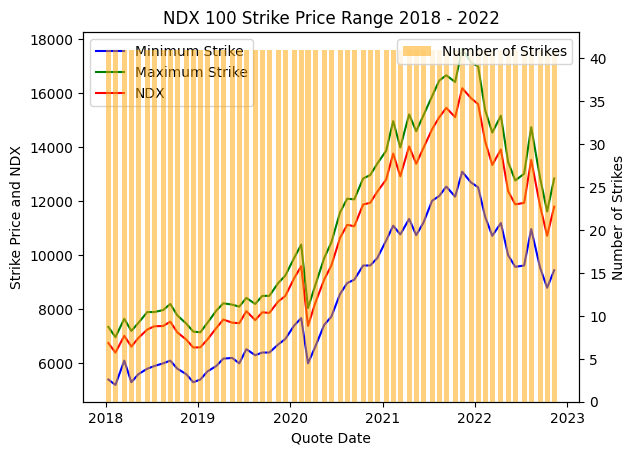

In [214]:
fig, ax1 = plt.subplots()
ax1.plot(sampled_data.groupby("quote_date").apply(strike_min), label="Minimum Strike", color='b')
ax1.plot(sampled_data.groupby("quote_date").apply(strike_max), label="Maximum Strike", color='g')
ax1.plot(sampled_data.groupby("quote_date").apply(NDX), label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')
# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(sampled_data.groupby("quote_date").apply(lambda x: x.name), 
        sampled_data.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("NDX 100 Strike Price Range 2018 - 2022")
plt.show()

## Simple Sample Approach

Take uniform samples of such size for which strikes exist every day for a consistent time-series. Relationship between strikes on different days are determined by ranking them.

In [215]:
n_strikes = merged_data_new.groupby("quote_date").apply(group_length).min()
n_strikes

67

In [216]:
def get_sample(group):
     return group.sample(n=n_strikes, replace = False)

sampled_data = merged_data_new.groupby("quote_date").apply(get_sample).reset_index(drop = True).sort_values(by = ['quote_date', 'strike']).reset_index(drop = True)
sampled_data

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,adjusted_strike
0,2018-01-12,2018-02-09,5400.0,1347.0,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,0.800
1,2018-01-12,2018-02-09,5500.0,1248.0,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067,0.815
2,2018-01-12,2018-02-09,5800.0,953.1,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,0.859
3,2018-01-12,2018-02-09,6100.0,658.0,672.10,6.40,9.0,2018-01-12,0.0131,6750.737660,650.737660,6751.233067,0.904
4,2018-01-12,2018-02-09,6125.0,633.6,647.70,6.90,9.7,2018-01-12,0.0131,6750.710560,625.710560,6751.233067,0.907
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,2022-11-11,2022-12-09,13875.0,3.4,5.90,2020.30,2044.9,2022-11-11,0.0371,11804.993580,-2070.006420,11805.333099,1.175
3949,2022-11-11,2022-12-09,13975.0,2.5,5.10,2119.60,2144.0,2022-11-11,0.0371,11804.640471,-2170.359529,11805.333099,1.184
3950,2022-11-11,2022-12-09,14000.0,2.3,4.90,2144.40,2168.7,2022-11-11,0.0371,11804.614694,-2195.385306,11805.333099,1.186
3951,2022-11-11,2022-12-09,14300.0,0.7,3.40,2442.00,2466.4,2022-11-11,0.0371,11804.505366,-2495.494634,11805.333099,1.211


In [217]:
sampled_data['ranked_strikes'] = sampled_data.groupby('quote_date')['strike'].rank(method='dense').astype(int)
sampled_data

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,adjusted_strike,ranked_strikes
0,2018-01-12,2018-02-09,5400.0,1347.0,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,0.800,1
1,2018-01-12,2018-02-09,5500.0,1248.0,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067,0.815,2
2,2018-01-12,2018-02-09,5800.0,953.1,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,0.859,3
3,2018-01-12,2018-02-09,6100.0,658.0,672.10,6.40,9.0,2018-01-12,0.0131,6750.737660,650.737660,6751.233067,0.904,4
4,2018-01-12,2018-02-09,6125.0,633.6,647.70,6.90,9.7,2018-01-12,0.0131,6750.710560,625.710560,6751.233067,0.907,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,2022-11-11,2022-12-09,13875.0,3.4,5.90,2020.30,2044.9,2022-11-11,0.0371,11804.993580,-2070.006420,11805.333099,1.175,63
3949,2022-11-11,2022-12-09,13975.0,2.5,5.10,2119.60,2144.0,2022-11-11,0.0371,11804.640471,-2170.359529,11805.333099,1.184,64
3950,2022-11-11,2022-12-09,14000.0,2.3,4.90,2144.40,2168.7,2022-11-11,0.0371,11804.614694,-2195.385306,11805.333099,1.186,65
3951,2022-11-11,2022-12-09,14300.0,0.7,3.40,2442.00,2466.4,2022-11-11,0.0371,11804.505366,-2495.494634,11805.333099,1.211,66


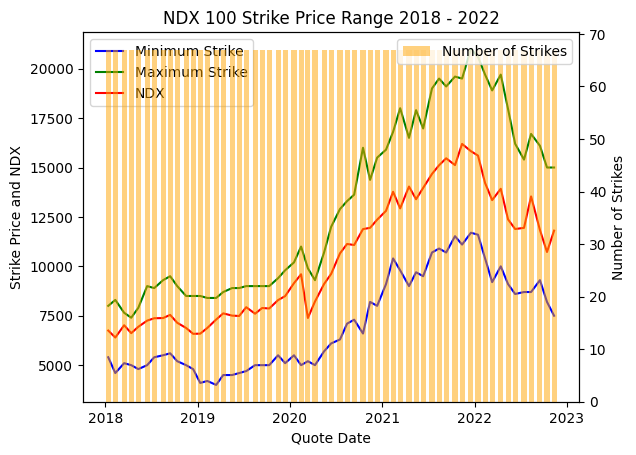

In [218]:
fig, ax1 = plt.subplots()
ax1.plot(sampled_data.groupby("quote_date").apply(strike_min), label="Minimum Strike", color='b')
ax1.plot(sampled_data.groupby("quote_date").apply(strike_max), label="Maximum Strike", color='g')
ax1.plot(sampled_data.groupby("quote_date").apply(NDX), label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')
# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(sampled_data.groupby("quote_date").apply(lambda x: x.name), 
        sampled_data.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("NDX 100 Strike Price Range 2018 - 2022")
plt.show()

In [219]:
sampled_data_new = pd.merge(left = sampled_data, right = NDX_100, left_on = 'expiration_C', right_on = 'Date', how = 'left')
sampled_data_new['PNL_C'] = np.maximum(sampled_data_new['NDX_Exp'] - sampled_data_new['strike'],0) - (sampled_data_new['bid_1545_C'])
sampled_data_new['PNL_P'] = np.maximum(sampled_data_new['strike'] - sampled_data_new['NDX_Exp'],0) - (sampled_data_new['bid_1545_P'])
sampled_data_new['PNL_C_S'] = -np.maximum(sampled_data_new['NDX_Exp'] - sampled_data_new['strike'],0) + (sampled_data_new['ask_1545_C'])
sampled_data_new['PNL_P_S'] = -np.maximum(sampled_data_new['strike'] - sampled_data_new['NDX_Exp'],0) + (sampled_data_new['ask_1545_P'])
PNL_data = sampled_data_new[['quote_date',
                             'strike',
                             'ranked_strikes',
                             'implied_S_y',
                             'NDX_Exp',
                             'bid_1545_C',
                             'ask_1545_C',
                             'bid_1545_P',
                             'ask_1545_P',
                             'PNL_C',
                             'PNL_P',
                             'PNL_C_S',
                             'PNL_P_S']]
PNL_data

,quote_date,strike,ranked_strikes,implied_S_y,NDX_Exp,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,PNL_C,PNL_P,PNL_C_S,PNL_P_S
0,2018-01-12,5400.0,1,6751.233067,6412.68,1347.0,1368.30,0.05,3.1,-334.32,-0.05,355.62,3.10
1,2018-01-12,5500.0,2,6751.233067,6412.68,1248.0,1269.00,0.25,3.7,-335.32,-0.25,356.32,3.70
2,2018-01-12,5800.0,3,6751.233067,6412.68,953.1,967.40,2.40,5.1,-340.42,-2.40,354.72,5.10
3,2018-01-12,6100.0,4,6751.233067,6412.68,658.0,672.10,6.40,9.0,-345.32,-6.40,359.42,9.00
4,2018-01-12,6125.0,5,6751.233067,6412.68,633.6,647.70,6.90,9.7,-345.92,-6.90,360.02,9.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,2022-11-11,13875.0,63,11805.333099,11563.33,3.4,5.90,2020.30,2044.9,-3.40,291.37,5.90,-266.77
3949,2022-11-11,13975.0,64,11805.333099,11563.33,2.5,5.10,2119.60,2144.0,-2.50,292.07,5.10,-267.67
3950,2022-11-11,14000.0,65,11805.333099,11563.33,2.3,4.90,2144.40,2168.7,-2.30,292.27,4.90,-267.97
3951,2022-11-11,14300.0,66,11805.333099,11563.33,0.7,3.40,2442.00,2466.4,-0.70,294.67,3.40,-270.27


In [220]:
call_PNL = PNL_data.pivot(index='quote_date', columns='ranked_strikes', values='PNL_C')
put_PNL = PNL_data.pivot(index='quote_date', columns='ranked_strikes', values='PNL_P')
call_S_PNL = PNL_data.pivot(index='quote_date', columns='ranked_strikes', values='PNL_C_S')
put_S_PNL = PNL_data.pivot(index='quote_date', columns='ranked_strikes', values='PNL_P_S') 
call_PNL.columns = [f"{col}_C" for col in call_PNL.columns]
put_PNL.columns = [f"{col}_P" for col in put_PNL.columns]
call_S_PNL.columns = [f"{col}_C_S" for col in call_S_PNL.columns]
put_S_PNL.columns = [f"{col}_P_S" for col in put_S_PNL.columns]
option_PNL = pd.merge(call_PNL , put_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , call_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , put_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL

,1_C,2_C,3_C,4_C,5_C,6_C,7_C,8_C,9_C,10_C,...,58_P_S,59_P_S,60_P_S,61_P_S,62_P_S,63_P_S,64_P_S,65_P_S,66_P_S,67_P_S
quote_date,,,,,,,,,,,,,,,,,,,,,
2018-01-12,-334.32,-335.32,-340.42,-345.32,-345.92,-347.72,-348.52,-350.32,-352.62,-353.92,...,-335.12,-335.32,-336.02,-334.32,-335.32,-335.32,-335.42,-336.32,-336.52,-336.82
2018-02-09,702.88,701.48,699.88,697.98,695.78,692.98,689.98,681.38,679.98,671.98,...,704.68,704.38,704.08,703.98,703.88,703.88,703.68,703.48,702.88,702.58
2018-03-16,-389.26,-395.76,-396.46,-397.26,-398.66,-399.16,-400.76,-403.96,-405.86,-407.16,...,-375.16,-375.96,-382.46,-385.26,-389.66,-391.56,-394.26,-394.86,-395.66,-395.26
2018-04-13,331.06,329.26,328.36,327.06,323.16,320.36,316.96,303.36,301.16,298.96,...,277.40,295.20,313.90,353.40,351.66,348.06,338.46,333.36,331.46,330.36
2018-05-11,214.02,214.32,213.52,213.82,213.52,212.62,213.12,213.02,212.92,212.82,...,208.70,227.90,221.82,211.62,207.62,211.82,211.02,210.52,210.12,209.82
2018-06-15,119.92,119.62,118.72,118.32,117.82,115.32,114.62,113.82,112.32,108.72,...,121.02,120.02,118.72,118.22,116.22,115.42,114.92,115.12,114.02,113.32
2018-07-13,35.90,35.20,29.20,26.60,24.00,23.80,23.10,20.90,20.20,18.40,...,54.80,42.90,35.50,32.80,31.50,32.30,32.10,31.80,30.70,30.10
2018-08-17,163.60,163.10,162.60,157.40,156.20,155.80,153.70,152.00,151.60,151.00,...,159.90,160.00,159.80,159.80,159.70,159.60,159.30,158.60,158.40,158.00
2018-09-14,-386.09,-386.49,-386.89,-387.29,-387.79,-388.29,-388.99,-389.69,-390.69,-391.79,...,-390.89,-391.09,-390.69,-391.59,-391.79,-391.99,-392.19,-392.49,-392.69,-392.89


In [221]:
option_PNL.corr()

,1_C,2_C,3_C,4_C,5_C,6_C,7_C,8_C,9_C,10_C,...,58_P_S,59_P_S,60_P_S,61_P_S,62_P_S,63_P_S,64_P_S,65_P_S,66_P_S,67_P_S
1_C,1.000000,0.999995,0.999979,0.999938,0.999879,0.999836,0.999767,0.999568,0.999202,0.998623,...,0.995256,0.995977,0.996954,0.997843,0.998112,0.998347,0.998547,0.998751,0.999862,0.999875
2_C,0.999995,1.000000,0.999989,0.999958,0.999907,0.999870,0.999803,0.999610,0.999245,0.998675,...,0.995237,0.995960,0.996938,0.997829,0.998107,0.998341,0.998540,0.998743,0.999851,0.999864
3_C,0.999979,0.999989,1.000000,0.999985,0.999953,0.999924,0.999870,0.999704,0.999376,0.998841,...,0.995155,0.995878,0.996862,0.997763,0.998044,0.998280,0.998478,0.998681,0.999798,0.999812
4_C,0.999938,0.999958,0.999985,1.000000,0.999985,0.999963,0.999920,0.999781,0.999482,0.998966,...,0.995086,0.995807,0.996763,0.997669,0.997958,0.998195,0.998389,0.998592,0.999717,0.999730
5_C,0.999879,0.999907,0.999953,0.999985,1.000000,0.999990,0.999969,0.999864,0.999609,0.999142,...,0.994949,0.995670,0.996637,0.997549,0.997840,0.998078,0.998272,0.998476,0.999609,0.999622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63_P_S,0.998347,0.998341,0.998280,0.998195,0.998078,0.998017,0.997877,0.997541,0.997024,0.996836,...,0.997826,0.998432,0.999378,0.999757,0.999980,1.000000,0.999986,0.999954,0.998832,0.998718
64_P_S,0.998547,0.998540,0.998478,0.998389,0.998272,0.998210,0.998063,0.997728,0.997204,0.996965,...,0.997807,0.998409,0.999337,0.999738,0.999949,0.999986,1.000000,0.999988,0.999016,0.998912
65_P_S,0.998751,0.998743,0.998681,0.998592,0.998476,0.998414,0.998267,0.997933,0.997408,0.997129,...,0.997771,0.998378,0.999290,0.999717,0.999897,0.999954,0.999988,1.000000,0.999189,0.999096
66_P_S,0.999862,0.999851,0.999798,0.999717,0.999609,0.999549,0.999419,0.999106,0.998591,0.997943,...,0.995841,0.996553,0.997527,0.998340,0.998630,0.998832,0.999016,0.999189,1.000000,0.999997


In [222]:
option_PNL.to_csv("option_PNL.csv")

## Examine NDX std

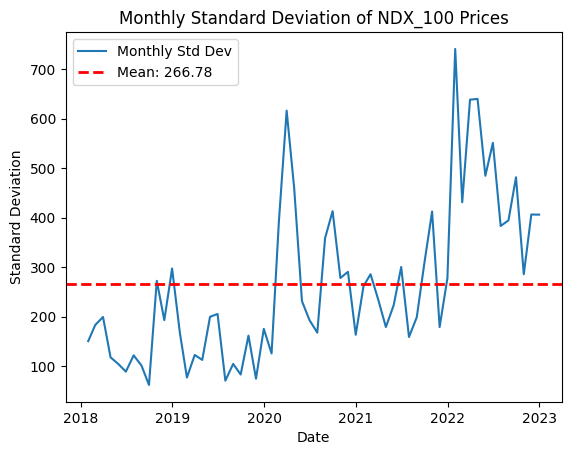

In [223]:
NDX_100['Date'] = pd.to_datetime(NDX_100['Date'])
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2022-12-31')
NDX_100 = NDX_100[(NDX_100['Date'] >= start_date) & (NDX_100['Date'] <= end_date)]
NDX_100.set_index('Date', inplace=True)
std = NDX_100['NDX_Exp'].groupby(pd.Grouper(freq='M')).std()
plt.plot(std, label='Monthly Std Dev')
mean_std = std.mean()
plt.axhline(mean_std, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_std:.2f}')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.title('Monthly Standard Deviation of NDX_100 Prices')
plt.legend()
plt.show()

## Examine PNLs

In [224]:
option_PNL.mean()

1_C       124.960169
2_C       123.399153
3_C       121.241525
4_C       118.812712
5_C       116.656780
             ...    
63_P_S    121.620339
64_P_S    121.471186
65_P_S    120.944068
66_P_S    123.988136
67_P_S    123.739831
Length: 268, dtype: float64

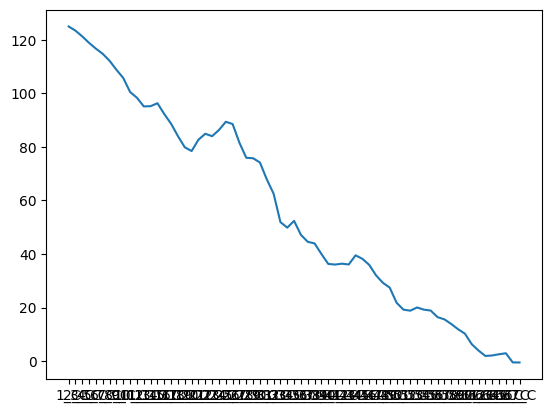

In [227]:
plt.plot(option_PNL.mean()[0:67])
plt.show()

## Where are at the money strikes?